# Workshop 2 - ArcGIS Survey 123 data analysis

In [13]:
# using Python to initialize GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image
import pandas as pd

# create GRASS GIS runtime environment
gisbase = "/usr/local/grass79" #subprocess.check_output(["grass79", "--config", "path"], text=True).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# do GRASS GIS imports
import grass.script as gs
import grass.script.setup as gsetup

# set GRASS GIS session data
# rcfile = gsetup.init(gisbase, "/home/jovyan/grassdata", "nc_spm_08_grass7", "user1")
rcfile = gsetup.init(gisbase, "/home/coreywhite/Documents/grassdata", "wrri_nad83_6542", "tomorrownow")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Define Varibales

In [2]:
survey ="surveyPoint@PERMANENT"
w2_survey_results = "w2_survey_results"

# QL2 DEM
dem = "dem_10m_mosaic@wrri10m"
hillshade = "dem_10m_hillshade"

# Political Boundaries
nc_state = "nc_state@PERMANENT"
research_triangle = "ResearchTriangle@PERMANENT"
research_triangle_core = "ResearchTriangleCore@PERMANENT"

building_footprints = "building_footprints@PERMANENT"

# Hydrological Boundaries
huc_12 = "wbd_huc_10_12@PERMANENT"
research_triangle_huc12 = "research_triangle_huc12"
watersheds = "watersheds_huc_10@wrri10m"
basins = "basins_huc_8@wrri10m"

#Floodplains
floodplain_orange = "floodplains_orange_co@PERMANENT"
floodplain_wake = "floodplains_wake_co@PERMANENT"
# Derived Hydro Features
direction = "direction_3k"
basins = "basin_3k"
streams = "streams_3k"
accumulation = "accum_3k"
topidx = "topidx_10m"
inundation = "1m_inundation"
extracted_streams = "streams_3k_ext"
above_stream = "above_stream"



#Land Cover
lcmap_2017 = "LCMAP_CU_2017_V01_LCPRI@PERMANENT"
nlcd_2016 = "NLCD_2016_Land_Cover_L48_20190424@PERMANENT"
# gs.run_command("r.reclass", input=nlcd_2016, output="nlcd_2016_labeled", rules="grass_config/nlcd_reclass.txt", overwrite=True)
nlcd_2016 = "nlcd_2016_labeled"
nlcd_2016_blend = "nlcd_2016_blend"


In [14]:
nlcd_class_map ={
    11: "Open Water",
    21: "Developed (Open Space)",
    22: "Developed (Low Intensity)",
    23: "Developed (Medium Intensity)",
    24: "Developed (High Intensity)",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

nlcd_top_level_class_map ={
    11: "Water",
    21: "Developed",
    22: "Developed",
    23: "Developed",
    24: "Developed",
    31: "Barren",
    41: "Forest",
    42: "Forest",
    43: "Forest",
    51: "Shrubland",
    52: "Shrubland",
    71: "Herbaceous",
    81: "Planted/Cultivated",
    82: "Planted/Cultivated",
    90: "Wetlands",
    95: "Wetlands"
}

## Set Computational Region

In [70]:
gs.parse_command('g.region', vector=research_triangle, res=10, flags='pg')


{'projection': '99',
 'zone': '0',
 'n': '310235.5555',
 's': '167250.0967',
 'w': '559202.8574',
 'e': '698392.8363',
 'nsres': '9.99968241',
 'ewres': '9.99999848',
 'rows': '14299',
 'cols': '13919',
 'cells': '199027781'}

### Create layer of subwatersheds that overlap the Triangle

In [4]:
gs.run_command("v.select",
    overwrite=True, 
    ainput=huc_12, 
    binput=research_triangle, 
    output=research_triangle_huc12, 
    operator="overlap")

### Reset computational region to the subwatersheds that overlap the Triangle

In [151]:
#Set computational region and mask
gs.parse_command('g.region', raster=dem, res=10, flags='pg')
gs.run_command("r.mask", vector=research_triangle_huc12, overwrite=True)

## Calculate Flow Direction
gs.run_command("r.watershed",
    overwrite=True,
    flags="m",
    elevation=dem, 
    threshold=3000,
    accumulation=accumulation,
    drainage=direction,
    basin=basins,
    stream=streams,
    convergence=5,
    memory=10000       
)

In [177]:
# gs.run_command("r.mask", flags="r")
# gs.parse_command('g.region', raster=dem, res=10, flags='pg')
# gs.run_command("r.mask", vector=research_triangle_huc12)


gs.run_command("r.stream.extract",
    overwrite=True,
    elevation=dem,
    accumulation=accumulation,
    threshold=3000,
    mexp=0,
    stream_length=0,
    memory=10000,
    stream_raster=extracted_streams, 
    stream_vector=extracted_streams)

In [5]:
gs.run_command('g.region', raster=dem, res=10, flags='pg')
# gs.run_command("r.mask", flags="r")
gs.run_command("r.mask", vector=research_triangle_huc12, overwrite=True)
gs.run_command("r.topidx", input=dem, output=topidx, overwrite=True)

In [6]:
gs.parse_command('g.region', vector=research_triangle_huc12, res=10, flags='pg')
gs.parse_command("v.info", map=research_triangle_huc12)

{'+----------------------------------------------------------------------------+': None,
 '| Name:            research_triangle_huc12                                   |': None,
 '| Mapset:          tomorrownow                                               |': None,
 '| Location:        wrri_nad83_6542                                           |': None,
 '| Database:        /home/coreywhite/Documents/grassdata                      |': None,
 '| Title:                                                                     |': None,
 '| Map scale:       1:1                                                       |': None,
 '| Name of creator: coreywhite                                                |': None,
 '| Organization:                                                              |': None,
 '| Source date:     Mon Apr  5 12:37:38 2021                                  |': None,
 '| Timestamp (first layer): none                                              |': None,
 '|------------------

### Set a compuational mask to the subwatersheds that overlap the Triangle

## Create a new feature containing only survey points added during Workshop 2

In [ ]:
# Filter survey results to the day of Workshop 2
gs.run_command("v.extract", overwrite=True, input=survey, where="CreationDa = '2019-04-12'", output=w2_survey_results)
gs.parse_command("v.info", map=w2_survey_results)
gs.parse_command("v.info", map=w2_survey_results, flags="c")

The featureset should now contain 31 points

### Identify spatial clusters in the survey data

In [7]:
# Indetify clusters from the survey using the density algorithm 
w2_survey_clusters = "w2_survey_clusters"
gs.parse_command('g.region', vector=w2_survey_clusters, res=10, flags='pg')
gs.run_command("v.cluster", overwrite=True, verbose=True, input=w2_survey_results, output=w2_survey_clusters, layer=2, distance=1000, min=3, method="dbscan")

Three clusters should be identified with a fourth group defined as group -1 which is the remaining unclustered points

### Extrat each cluster into its own feature

In [7]:
cluster_ids = [1,2,3]
clusters = []
cluster_centerpoints = []
cluster_outlets = []
cluster_contributing_areas = []
cluster_building_footprints = []
cluster_contrib_streams_list = []
cluster_neighborhood_age = []
cluster_drain = []
hulls = []
cluster_huc12s = []
cluster_huc10s = []
floodplains= []
def repopulateLayerLists():
  
    for c in cluster_ids:
        output = "cluster_{}".format(c)
        clusters.append(output)
        output_hull = "{}_hull".format(output)
        hulls.append(output_hull)
        cluster_huc12s_output = "{}_huc_12".format(output)
        cluster_huc12s.append(cluster_huc12s_output)
        cluster_huc10s_output = "{}_huc_10".format(output)
        cluster_huc10s.append(cluster_huc10s_output)
        centerpoints = "{}_centerpoint".format(output)
        cluster_centerpoints.append(centerpoints)
        outlet = "{}_outlet".format(output)
        cluster_outlets.append(outlet)
        contributing_area = "{}_contrib_area".format(output)
        cluster_contributing_areas.append(contributing_area)
        drainage = "{}_drainage".format(output)
        cluster_drain.append(drainage)
        drain_dir = "direction_deg_3k"
        cluster_bf= "{}_building_footprints".format(contributing_area)
        cluster_building_footprints.append(cluster_bf)
        cluster_contrib_streams= "{}_streams_3k".format(contributing_area)
        cluster_contrib_streams_list.append(cluster_contrib_streams)
        age = "{}_neighborhood_age".format(building_footprints)
        cluster_neighborhood_age.append(age)
        cluster_floodplain = "{}_floodplain".format(output)
        floodplains.append(cluster_floodplain)

repopulateLayerLists()

In [160]:
def calcuateNeighborhoodAge(cluster, building_footprints, contributing_area, res=10):
    gs.parse_command('g.region', vector=contributing_area, res=res, flags='pg')
    gs.run_command("r.mask", vector=contributing_area, overwrite=True)
    print("Cluster {}: Extracting Building Footprint".format(cluster))
    cluster_bf_overlap = "{}_building_footprints_overlap".format(contributing_area)
    # cluster_building_footprints_overlap.append(cluster_bf_overlap)
    gs.run_command("v.select",
        ainput=building_footprints, 
        atype="area",
        binput=contributing_area, 
        btype="area",
        blayer=1, 
        output=cluster_bf_overlap, 
        operator="overlap", 
        overwrite=True)

    print("Cluster {}: Clipping Building Footprint".format(cluster))
    cluster_bf= "{}_building_footprints".format(contributing_area)
    # cluster_building_footprints.append(cluster_bf)
    gs.run_command("v.clip", 
        input=cluster_bf_overlap, 
        clip=contributing_area, 
        output=cluster_bf,
        overwrite=True)
   
    building_footprints = cluster_bf
    centroid = "{}_centroid".format(building_footprints)
    point = "{}_point".format(building_footprints)
    age = "{}_neighborhood_age".format(building_footprints)
    gs.run_command("v.db.addcolumn", map=building_footprints,layer=1, columns="year integer")
    gs.run_command("v.db.update", map=building_footprints, layer=1, column="year", qcol="year_built")
    gs.run_command("v.extract", input=building_footprints, layer=1, output=centroid, type="centroid", overwrite=True)

    gs.run_command("v.to.points", input=centroid, layer=1, output=point, type="centroid", overwrite=True)
    print("\tCalculating Neighborhood Age Surface")
    gs.run_command("v.surf.rst", input=point, elevation=age, zcolumn="year", nprocs=14, where="year > 0", npmin=10, segmax=5)
    year_int = "{}_int".format(age)
    gs.run_command("r.mapcalc", expression="{} = int({})".format(year_int, age))
    year_int_reclass = "{}_reclass".format(year_int)
    gs.run_command("r.reclass", input=year_int, output=year_int_reclass, rules="grass_config/development_age_reclass.txt", overwrite=True)
    gs.run_command("r.colors", map=year_int_reclass, rules="grass_config/development_age_color.txt")
    # return year_int_reclass
    # Display Map
    gs.run_command('d.erase')
    # gs.run_command("g.region", e="e+5350")
# initiate the rendering
    # gs.run_command("d.mon", start="cairo", output="cluster_{}_year_of_development.png".format(cluster))
    gs.run_command('d.rast', map=year_int_reclass)
    gs.run_command('d.vect', map=cluster_contributing_areas[cluster],color="77:77:77:255", fill_color="none", width=2)
    gs.run_command('d.vect', map=cluster_contrib_streams_list[cluster], color="30:144:255:255")
    # gs.run_command('d.vect', map=cluster_building_footprints[cluster], color="grey", fill_color="grey")
    # gs.run_command('d.vect', map=cluster_huc10s[cluster], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"
    gs.run_command('d.vect', map=cluster_outlets[cluster], icon="basic/point",fill_color="black", layer=2, size=20)
    gs.run_command('d.barscale', flags='n')    
    # gs.run_command('d.legend', raster=year_int_reclass,flags="cn", font="sans", at=[20,80,70,75], title="Decade Developed")
    return Image(filename="map.png")


In [49]:
cluster_ids = [1,2,3]
clusters = []
cluster_centerpoints = []
cluster_outlets = []
cluster_contributing_areas = []
cluster_building_footprints = []
cluster_building_footprints_overlap = []
cluster_contrib_streams_overlap_list =[]
cluster_contrib_streams_list = []
cluster_drain = []
hulls = []
cluster_huc12s = []
cluster_huc10s = []
for c in cluster_ids:
    gs.parse_command('g.region', raster=direction, res=10, flags='pg')

    gs.run_command("r.mask", vector=research_triangle_huc12, overwrite=True)
    
    # Extract the cluster from the cluster output
    output = "cluster_{}".format(c)
    clusters.append(output)
    # gs.run_command('v.extract', 
    #     overwrite=True, 
    #     input=w2_survey_clusters, 
    #     layer=2, 
    #     type="point", 
    #     cats=c, 
    #     output=output)
   
    # Generate a convex hull for the cluster
    output_hull = "{}_hull".format(output)
    hulls.append(output_hull)
    # gs.run_command('v.hull', 
    #     overwrite=True, 
    #     input=output, 
    #     layer=2, 
    #     output=output_hull)

    # Select subwatersheds containing cluster
    cluster_huc12s_output = "{}_huc_12".format(output)
    cluster_huc12s.append(cluster_huc12s_output)
    # gs.run_command("v.select", 
    #     ainput=huc_12, 
    #     binput=output, 
    #     blayer=2, 
    #     output=cluster_huc12s_output, 
    #     operator="overlap")
    
    # Select watersheds containing cluster
    cluster_huc10s_output = "{}_huc_10".format(output)
    cluster_huc10s.append(cluster_huc10s_output)
    # gs.run_command("v.select", 
    #     ainput=watersheds, 
    #     binput=output, 
    #     blayer=2, 
    #     output=cluster_huc10s_output, 
    #     operator="overlap")

    # Create Cluster Center Point
    centerpoints = "{}_centerpoint".format(output)
    cluster_centerpoints.append(centerpoints)
    # gs.run_command("v.centerpoint",
    #      input=output,
    #      layer=2,
    #      type="point", 
    #      output=centerpoints,
    #      acenter="median", 
    #      overwrite=True)

    # Snap Cluster Center Point to Stream
    outlet = "{}_outlet".format(output)
    cluster_outlets.append(outlet)
    # gs.run_command("r.stream.snap",
    #     overwrite=True,
    #     input=output, 
    #     output=outlet, 
    #     stream_rast=streams, 
    #     accumulation=accumulation,
    #     radius=100,
    #     memory=10000,
    #     threshold=10000
    # )

    # Calculate Contributing Area
    contributing_area = "{}_contrib_area".format(output)
    cluster_contributing_areas.append(contributing_area)
    # gs.run_command("r.stream.basins",
    #     direction=direction,
    #     points=outlet,
    #     memory=10000,
    #     basins=contributing_area
    # )

    # Convert to vector for displaying
    # gs.run_command("r.to.vect", overwrite=True, input=contributing_area, output=contributing_area, type="area")

    # Calculate Drainage
    drainage = "{}_drainage".format(output)
    cluster_drain.append(drainage)
    drain_dir = "direction_deg_3k"
    # gs.run_command("r.mapcalc", 
    #     expression="{} = if({} != 0, 45. * abs({}), null())".format(drain_dir,direction, direction),
    #     overwrite=True)
    # gs.run_command("r.drain",
    #     input=dem,
    #     direction=drain_dir,
    #     output=drainage, 
    #     drain=drainage, 
    #     start_points=outlet)

    #Extract Buildings
    print("Cluster {}: Extracting Building Footprint".format(c))
    cluster_bf_overlap = "{}_building_footprints_overlap".format(contributing_area)
    cluster_building_footprints_overlap.append(cluster_bf_overlap)
    gs.run_command("v.select",
        ainput=building_footprints, 
        atype="area",
        binput=contributing_area, 
        btype="area",
        blayer=1, 
        output=cluster_bf_overlap, 
        operator="overlap", 
        overwrite=True)

    print("Cluster {}: Clipping Building Footprint".format(c))
    cluster_bf= "{}_building_footprints".format(contributing_area)
    cluster_building_footprints.append(cluster_bf)
    gs.run_command("v.clip", 
        input=cluster_bf_overlap, 
        clip=contributing_area, 
        output=cluster_bf,
        overwrite=True)

    # Extract Streams for contributing area
    print("Cluster {}: Extracting 3k Streams".format(c))
    cluster_contrib_streams_overlap = "{}_streams_3k_overlap".format(contributing_area)
    cluster_contrib_streams_overlap_list.append(cluster_contrib_streams_overlap)
    gs.run_command("v.select",
        ainput=extracted_streams, 
        atype="line",
        binput=contributing_area, 
        btype="area",
        blayer=1, 
        output=cluster_contrib_streams_overlap, 
        operator="overlap", 
        overwrite=True)

    
    print("Cluster {}: Clipping 3k Streams".format(c))
    cluster_contrib_streams= "{}_streams_3k".format(contributing_area)
    cluster_contrib_streams_list.append(cluster_contrib_streams)
    gs.run_command("v.clip", 
        input=cluster_contrib_streams_overlap, 
        clip=contributing_area, 
        output=cluster_contrib_streams,
        overwrite=True)

    print("Cluster {}: Setting Computational Region and Analysis Mask to Contributing Area".format(c))
    # gs.parse_command('g.region', raster=contributing_area, res=10, flags='pg')
    # gs.run_command("r.mask", vector=contributing_area, overwrite=True)
    # print("Cluster {}: Calculating Neighborhood Age".format(c))
    # calcuateNeighborhoodAge(cluster_bf)




Cluster 1: Extracting Building Footprint
Cluster 1: Clipping Building Footprint
Cluster 1: Extracting 3k Streams
Cluster 1: Clipping 3k Streams
Cluster 1: Setting Computational Region and Analysis Mask to Contributing Area
Cluster 2: Extracting Building Footprint
Cluster 2: Clipping Building Footprint
Cluster 2: Extracting 3k Streams
Cluster 2: Clipping 3k Streams
Cluster 2: Setting Computational Region and Analysis Mask to Contributing Area
Cluster 3: Extracting Building Footprint
Cluster 3: Clipping Building Footprint
Cluster 3: Extracting 3k Streams
Cluster 3: Clipping 3k Streams
Cluster 3: Setting Computational Region and Analysis Mask to Contributing Area


In [ ]:
v.extract --overwrite input=cluster_1_floodplain@tomorrownow where="floodzone = 'AEFW'" output=cluster_1_floodway

In [117]:
def clip_floodplains_to_cluster():
    floodplains = []
    for c in range(0,3):
        gs.parse_command('g.region', vector=cluster_contributing_areas[c], res=10, flags='pg')
        gs.run_command("r.mask", vector=cluster_contributing_areas[c], overwrite=True)
        cluster_floodplain = "cluster_{}_floodplain".format(c + 1)
        cluster_floodway = "cluster_{}_floodway".format(c + 1)
        

        if c == 0:
            floodplain_clip = floodplain_orange
            floodway_query = "floodzone = 'AEFW'"
        else:
            floodplain_clip = floodplain_wake

        gs.run_command("v.extract",
            overwrite=True,
            input=floodplain_clip,
            where=floodway_query,
            output=cluster_floodway)

        gs.run_command("v.clip", 
            input=cluster_floodway, 
            clip=cluster_contributing_areas[c], 
            output=cluster_floodplain,
            overwrite=True)

        floodplains.append(cluster_floodplain)
    return floodplains

cluster_floodplains = clip_floodplains_to_cluster()

0
1
2


In [18]:
def calculateBuildingInFloodplain(buildings, floodplain):
    output = "{}_in_floodplain".format(buildings)
    gs.run_command("v.select",
        ainput=buildings, 
        atype="area",
        binput=floodplain, 
        btype="area",
        blayer=1, 
        output=output, 
        operator="overlap", 
        overwrite=True)

    total_buildings_in_floodplain = gs.parse_command('v.info', map=output, flags='get')
    print("Total Buildings in Floodplain: {}".format(total_buildings_in_floodplain['areas']))
    return output



## Map of all clusters center points

In [9]:
def mapClusterUpstream(clusterId, title=""):
    gs.run_command('d.erase')
    gs.run_command("r.mask", vector=cluster_huc12s[clusterId], overwrite=True)
    gs.parse_command('g.region', vector=cluster_huc12s[clusterId], res=10, flags='pg')

  
    gs.run_command('d.rast', map=nlcd_2016_blend)
    # gs.run_command("r.colors", map=cluster_contributing_areas[clusterId], rules="./figures/contributing_area_color.txt")
    gs.run_command('d.vect', map=cluster_contributing_areas[clusterId],color="77:77:77:255", fill_color="none", width=2)
    # gs.run_command('d.rast', map=streams)



    gs.run_command('d.vect', map=research_triangle, color="grey", fill_color="none", width=3)
    gs.run_command('d.vect', map=research_triangle_core, color="grey", fill_color="none", width=4, attribute_column="COUNTY", label_color="black", label_size=12, xref="center")

    gs.run_command('d.vect', map=cluster_huc10s[clusterId], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"

    
    gs.run_command('d.vect', map=cluster_drain[clusterId], color="blue")
    gs.run_command('d.vect', map=cluster_outlets[clusterId], icon="basic/point",fill_color="black", layer=2, size=20)

    gs.run_command('d.barscale', flags='n')
    gs.run_command('d.legend.vect', 
        input="./figures/cluster_{}_legend.txt".format(clusterId + 1), 
        bgcolor="255:255:255:255", 
        border_color="0:0:0:255", 
        fontsize=8,
        title="Legend",
        at="5,50",
        flags="b")
    gs.run_command("r.stats", flags="aclnA", input="{},{}".format(nlcd_2016,cluster_contributing_areas[clusterId]),output="./figures/cluster_{}_contrib_landuse.csv".format(clusterId + 1), separator=",")
    # gs.run_command('d.legend', raster=nlcd_2016)
    gs.run_command('d.text', text=title, size="4", flags="b",color="0:0:0:255", bgcolor="255:255:255:255", at="0,94")
    

    return Image(filename="map.png")

In [10]:
def landuseTabel(csv_path):
    df_cluster_1_landuse = pd.read_csv(csv_path, sep=",", names=['landclass', "landuse", "cluster", "km2","m2", "count"], index_col=False)
    df_cluster_1_landuse.head()
    df_cluster_1_landuse['landuse'] = df_cluster_1_landuse['landclass'].map(nlcd_class_map)
    df_cluster_1_landuse['landuse_group'] = df_cluster_1_landuse['landclass'].map(nlcd_top_level_class_map)
    print(df_cluster_1_landuse.head(20))
    df_cluster_1_landuse['km2'] = df_cluster_1_landuse['m2'].apply(lambda x: x / 1e6)
    df_cluster_1_landuse['percent'] = (df_cluster_1_landuse['count'] / df_cluster_1_landuse['count'].sum()) * 100
    df_cluster_1_landuse.head(50)
    print("Total Contributing Area: {}km2".format(df_cluster_1_landuse['km2'].sum()))
    return df_cluster_1_landuse.groupby(by="landuse_group").sum()[['km2', 'percent']].to_latex(index=True, label="cluster_1_contrib_landuse")



## Spatail Autocorration

In [15]:
def calculateSpatialAutoCorr(variable, landuse, output, method="moran"):
    """
    Calcuates spatial autocorrelation -1 perfect dispersion, 0 no autocorelation, 1 perfect clustering
    """
    gs.run_command("g.region", raster=variable)
    output = "{}_landuse_clump".format(output)
    gs.run_command("r.clump", input=landuse, output=output,overwrite=True)
    return gs.parse_command("r.object.spatialautocor", object_map=output, variable_map=variable, method=method, overwrite=True)

Building Footprints

In [584]:
calcuateNeighborhoodAge("cluster_1_contrib_area_building_footprints")

## Map of Cluster 1 - University Mall

In [114]:
landuseTabel("./figures/cluster_1_contrib_landuse.csv")

    landclass                       landuse  cluster  km2            m2  \
0          11                    Open Water       -1  NaN  3.541154e+05   
1          21        Developed (Open Space)       -1  NaN  1.713511e+07   
2          22     Developed (Low Intensity)       -1  NaN  6.548336e+06   
3          23  Developed (Medium Intensity)       -1  NaN  2.595780e+06   
4          24    Developed (High Intensity)       -1  NaN  5.602662e+05   
5          31                   Barren Land       -1  NaN  4.858840e+04   
6          41              Deciduous Forest       -1  NaN  7.985593e+06   
7          42              Evergreen Forest       -1  NaN  5.399111e+06   
8          43                  Mixed Forest       -1  NaN  5.099082e+06   
9          52                   Shrub/Scrub       -1  NaN  2.964292e+05   
10         71          Grassland/Herbaceous       -1  NaN  2.695356e+05   
11         81                   Pasture/Hay       -1  NaN  1.052249e+06   
12         82            

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &        km2 &    percent \\\\\nlanduse\\_group      &            &            \\\\\n\\midrule\nBarren             &   0.048588 &   0.101839 \\\\\nDeveloped          &  26.839491 &  56.254531 \\\\\nForest             &  18.483786 &  38.741299 \\\\\nHerbaceous         &   0.269536 &   0.564936 \\\\\nPlanted/Cultivated &   1.165422 &   2.442679 \\\\\nShrubland          &   0.296429 &   0.621304 \\\\\nWater              &   0.354115 &   0.742212 \\\\\nWetlands           &   0.253439 &   0.531199 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [14]:
cluster_1_elevation_morans = calculateSpatialAutoCorr(variable=dem, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_elevation_morans)

cluster_1_topidx_morans = calculateSpatialAutoCorr(variable=topidx, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_topidx_morans)

cluster_1_inundation_morans = calculateSpatialAutoCorr(variable=inundation, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_inundation_morans)

cluster_1_above_stream_morans = calculateSpatialAutoCorr(variable=above_stream, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_above_stream_morans)


{'nan': None}
{'nan': None}
{'nan': None}
{'nan': None}


In [80]:
# gs.parse_command("r.univar", map=inundation, flags="g")
gs.parse_command("r.colors", map=nlcd_2016, color="nlcd")

{}

In [169]:
def mapUpstreamContributingArea(cluster, floodplain):
    gs.run_command('d.erase')
    gs.parse_command('g.region', vector=cluster_contributing_areas[cluster], res=10, flags='pg')
    gs.run_command("r.mask", vector=cluster_contributing_areas[cluster], overwrite=True)
    gs.run_command('d.rast', map=nlcd_2016_blend)
   
    # gs.run_command("r.colors", map=cluster_contributing_areas[clusterId], rules="./figures/contributing_area_color.txt")
    gs.run_command('d.vect', map=cluster_contributing_areas[cluster],color="77:77:77:255", fill_color="none", width=2)
    gs.run_command('d.vect', map=cluster_contrib_streams_list[cluster], color="30:144:255:255")
    # gs.run_command('d.vect', map=floodplain)

    #  gs.run_command('d.rast', map=inundation)
    # gs.run_command('d.vect', map=cluster_building_footprints[cluster], color="grey", fill_color="grey")
    # gs.run_command('d.vect', map=cluster_building_footprints[cluster], color="255:165:0:255", fill_color="none")

    total_buildings = gs.parse_command('v.info', map=cluster_building_footprints[cluster], flags='get')
    print("Total Buildings: {}".format(total_buildings['areas']))
    # buildings_contrib_area_floodplain = calculateBuildingInFloodplain(cluster_building_footprints[cluster], floodplain)
    # gs.run_command('d.vect', map=buildings_contrib_area_floodplain, color="grey", fill_color="purple")
    # gs.run_command('d.vect', map=cluster_huc10s[cluster], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"
    gs.run_command('d.vect', map=cluster_outlets[cluster], icon="basic/point",fill_color="black", layer=2, size=20)
    # gs.run_command("d.legend", 
    #     raster=nlcd_2016, 
    #     flags="c",
    #     use=[11,21,22,23,24,31,41,42,43,52,71,81,82,90,95])


    gs.run_command('d.barscale', flags='n')
    return Image(filename="map.png")

Total Buildings: 11651


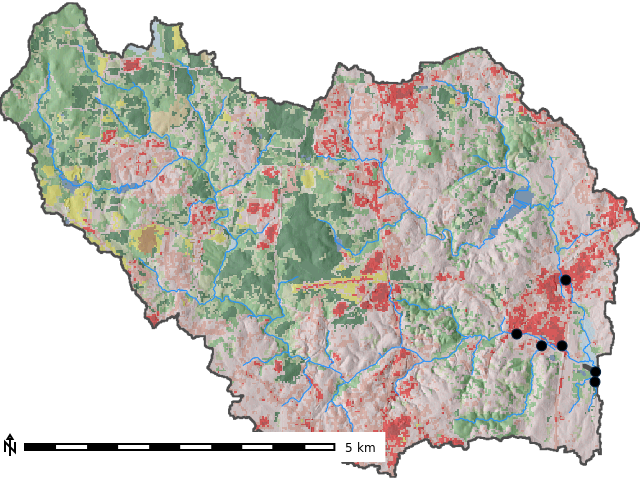

In [170]:
mapUpstreamContributingArea(0, floodplain_orange)


Cluster 0: Extracting Building Footprint
Cluster 0: Clipping Building Footprint
	Calculating Neighborhood Age Surface


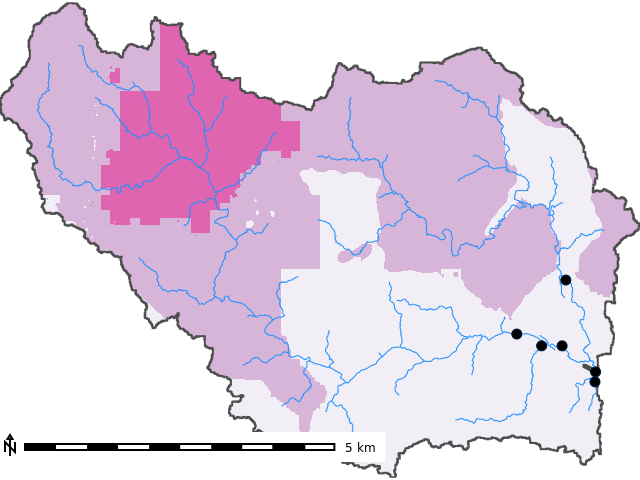

In [165]:
calcuateNeighborhoodAge(0,cluster_building_footprints[0],cluster_contributing_areas[0], 10)

Cluster 1: Extracting Building Footprint
Cluster 1: Clipping Building Footprint
	Calculating Neighborhood Age Surface


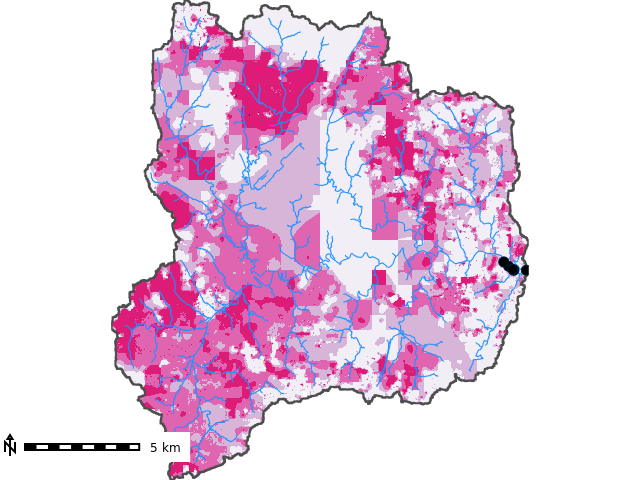

In [168]:
# calcuateNeighborhoodAge(0,building_footprints,"research_triangle_huc12", 30)
calcuateNeighborhoodAge(1,cluster_building_footprints[1],cluster_contributing_areas[1], 10)

In [122]:
landuseTabel("./figures/cluster_2_contrib_landuse.csv")

    landclass                       landuse  cluster  km2            m2  \
0          11                    Open Water       -1  NaN  7.976309e+05   
1          21        Developed (Open Space)       -1  NaN  2.379179e+07   
2          22     Developed (Low Intensity)       -1  NaN  1.156245e+07   
3          23  Developed (Medium Intensity)       -1  NaN  7.131900e+06   
4          24    Developed (High Intensity)       -1  NaN  1.678523e+06   
5          31                   Barren Land       -1  NaN  1.056011e+06   
6          41              Deciduous Forest       -1  NaN  8.233790e+06   
7          42              Evergreen Forest       -1  NaN  7.632168e+06   
8          43                  Mixed Forest       -1  NaN  9.577168e+06   
9          52                   Shrub/Scrub       -1  NaN  2.621787e+05   
10         71          Grassland/Herbaceous       -1  NaN  5.423490e+05   
11         81                   Pasture/Hay       -1  NaN  2.395491e+06   
12         82            

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &        km2 &    percent \\\\\nlanduse\\_group      &            &            \\\\\n\\midrule\nBarren             &   1.056011 &   1.404618 \\\\\nDeveloped          &  44.164662 &  58.744127 \\\\\nForest             &  25.443126 &  33.842311 \\\\\nHerbaceous         &   0.542349 &   0.721387 \\\\\nPlanted/Cultivated &   2.566912 &   3.414291 \\\\\nShrubland          &   0.262179 &   0.348728 \\\\\nWater              &   0.797631 &   1.060942 \\\\\nWetlands           &   0.348539 &   0.463597 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

Total Buildings: 52660


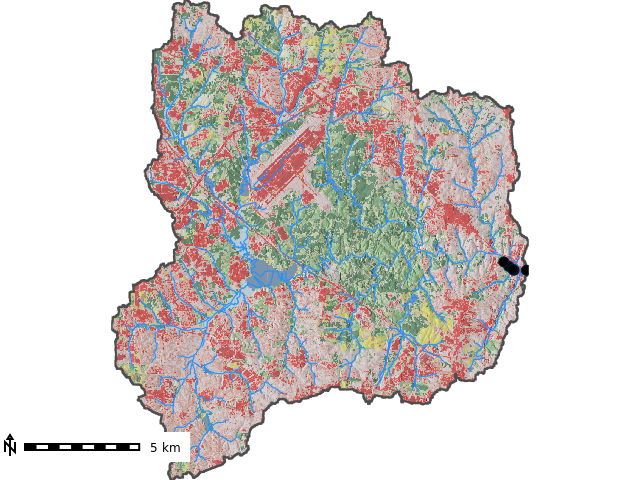

In [174]:

mapUpstreamContributingArea(1, floodplain_wake)


In [66]:
landuseTabel("./figures/cluster_3_contrib_landuse.csv")

    landclass                       landuse  cluster  km2             m2  \
0          21        Developed (Open Space)       -1  NaN  669168.127893   
1          22     Developed (Low Intensity)       -1  NaN  946454.920876   
2          23  Developed (Medium Intensity)       -1  NaN  878858.140474   
3          24    Developed (High Intensity)       -1  NaN  253887.907460   
4          31                   Barren Land       -1  NaN   95295.461130   
5          41              Deciduous Forest       -1  NaN   23298.890287   
6          42              Evergreen Forest       -1  NaN    4499.785678   
7          43                  Mixed Forest       -1  NaN    5899.719000   
8          71          Grassland/Herbaceous       -1  NaN    2599.876169   
9          81                   Pasture/Hay       -1  NaN   20699.014117   
10         82              Cultivated Crops       -1  NaN   45597.828201   

    count       landuse_group  
0    6692           Developed  
1    9465           Dev

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &       km2 &    percent \\\\\nlanduse\\_group      &           &            \\\\\n\\midrule\nBarren             &  0.095295 &   3.234456 \\\\\nDeveloped          &  2.748369 &  93.283329 \\\\\nForest             &  0.033698 &   1.143769 \\\\\nHerbaceous         &  0.002600 &   0.088243 \\\\\nPlanted/Cultivated &  0.066297 &   2.250204 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

Total Buildings: 896


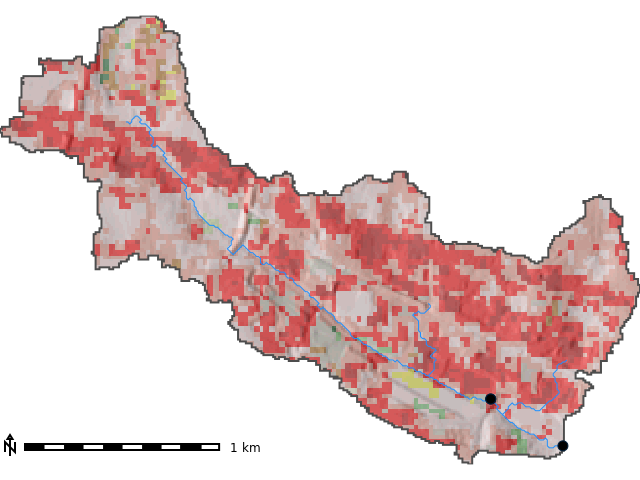

In [175]:
mapUpstreamContributingArea(2, floodplain_wake)


Cluster 2: Extracting Building Footprint
Cluster 2: Clipping Building Footprint
	Calculating Neighborhood Age Surface


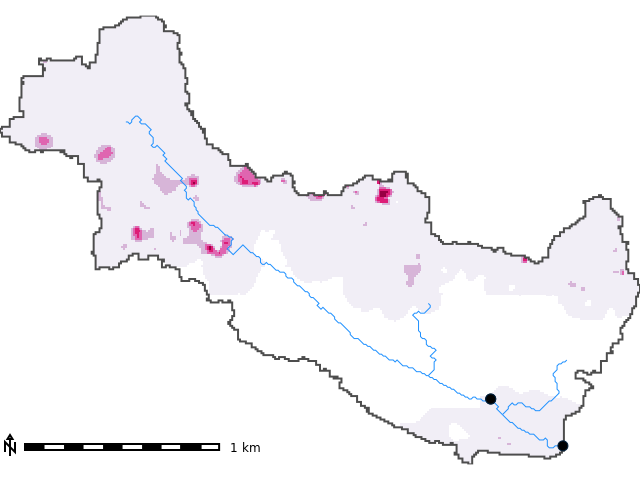

In [161]:
calcuateNeighborhoodAge(2,cluster_building_footprints[2],cluster_contributing_areas[2], 10)

In [77]:
def calculateHAND(depth=2):
    gs.run_command("r.mask", flags="r")
    # gs.run_command("r.mask", vector=cluster_huc10s[clusterId])
    gs.run_command('g.region', raster=streams, res=10, flags='pg')
    
    above_stream = "above_stream"
    gs.run_command("r.stream.distance", 
        overwrite=True, 
        stream_rast=streams, 
        direction=direction,
        elevation=dem, 
        method="downstream",
        difference=above_stream)
  
    output = "{}m_inundation".format(depth)
    gs.run_command("r.lake", overwrite=True, elevation=above_stream, water_level=depth, lake=output, seed=streams)
    return output



In [193]:


def simwe(cluster, elev, nlcd, display=True):
    dx = 'dx10m'
    dy = 'dy10m'
    cluster_idx = cluster - 1
    mannings = 'cluster_{}_mancover'.format(cluster)
    raincover = 'cluster_{}_raincover'.format(cluster)
    depth = 'cluster_{}_depth'.format(cluster)
    discharge = 'cluster_{}_discharge'.format(cluster)
    gs.run_command('d.erase')
    hull = "cluster_{}_hull".format(cluster)
    gs.parse_command('g.region', vector=cluster_contributing_areas[cluster_idx], res=10, flags='pg')
    gs.run_command("r.mask", vector=cluster_contributing_areas[cluster_idx], overwrite=True)

    # compute dx, dy
    gs.run_command("r.slope.aspect", elevation=elev, dx=dx, dy=dy, overwrite=True)

    # # Calculate manning coefficient
    gs.run_command("r.recode", input=nlcd, output=mannings, rules="grass_config/nlcd_to_mannings.txt")

    # # Calculate variable rainfall using nlcd
    gs.run_command("r.recode", input=nlcd, output=raincover, rules="grass_config/nlcd_to_rain.txt")

    # NOAA ATLAS 14 POINT PRECIPITATION FREQUENCY ESTIMATES
    # Get 100 year flood event critiera (Percipiation frequency)
    # https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_map_cont.html?bkmrk=nc

    # Duration | 100 yr 
    # 30 min     2.33 in
    # 60 min     3.21 in (79.248mm)

    # Calculate SCS Curve Number
    # https://serc.carleton.edu/hydromodules/steps/creating_excess.html
    # initial abstraction (la) = 0
    # continous abstraction (Fa) = S * (P-la)\(P-la + S)
        # Total Retention (S) = 0
        # Total Rainfall (P) = 79.248mm


    gs.run_command("r.sim.water", 
        elevation=elev, 
        dx=dx,
        dy=dy,
        rain_value=79.248,
        # rain=raincover,
        infil_value=0,
        man=mannings,
        depth=depth,
        disch=discharge,
        nwalk=1000000,
        nprocs=14,
        output_step=60, # Time step in minutes
        niterations=60 # Total time of event in minutes
    )

    # Extract flooded pixels with a depth >= 0.025m (~1in)
    filtered_depth = "cluster_{}_pf_100yr".format(cluster) 
    expression = "cluster_{}_pf_100yr = if({} >= 0.025,  {}, null())".format(cluster, depth,depth)
    gs.run_command("r.mapcalc", expression=expression, overwrite=True)
    gs.run_command("r.colors", map=filtered_depth, raster=depth)


    # Try blending different rasters together for display
    cluster_nlcd_blend = "cluster_{}_nlcd_2016_100yrfld_blend".format(cluster)
    cluster_nlcd_hillshade_blend = "cluster_{}_nlcd_2016_100yrfld_hillshade_blend".format(cluster)
    gs.run_command("r.blend", first=nlcd_2016, second=depth, output=cluster_nlcd_blend, flags="c")
    gs.run_command("r.blend", first=depth, second=hillshade, output="cluster_{}_1ooyr_flood_hillshade_blend".format(cluster), flags="c")
    gs.run_command("r.blend", first=cluster_nlcd_blend, second=hillshade, output=cluster_nlcd_hillshade_blend, flags="c")

    filtered_depth_blend = "{}_hillshade_blend".format(filtered_depth)
    gs.run_command("r.blend", first=filtered_depth, second=hillshade, output=filtered_depth_blend, flags="c")
    filtered_depth_nlcd_blend = "{}_hillshade_nlcd_blend".format(filtered_depth)
    gs.run_command("r.blend", first=filtered_depth_blend, second=nlcd_2016, output=filtered_depth_nlcd_blend, flags="c")


    if display:
        return display_simwe_depth_map(cluster)
    else:
        return filtered_depth_blend




def display_simwe_depth_map(cluster):
    depth = 'cluster_{}_depth'.format(cluster)
    hull = "cluster_{}_hull".format(cluster)
    filtered_depth = "cluster_{}_pf_100yr".format(cluster) 
    cluster_nlcd_blend = "cluster_{}_nlcd_2016_100yrfld_blend".format(cluster)
    cluster_nlcd_hillshade_blend = "cluster_{}_nlcd_2016_100yrfld_hillshade_blend".format(cluster)
    filtered_depth_blend = "{}_hillshade_blend".format(filtered_depth)
    filtered_depth_nlcd_blend = "{}_hillshade_nlcd_blend".format(filtered_depth)


    cluster_idx = cluster -1 # Cluster index used to find in list
    gs.run_command('g.region', vector=cluster_contributing_areas[cluster_idx], res=10, flags='pg')
    gs.run_command("r.mask", vector=cluster_contributing_areas[cluster_idx], overwrite=True)
    
    # Mpa Depth
    
    gs.run_command('d.erase')

    gs.run_command('d.rast', map=filtered_depth_blend)
   
    gs.run_command('d.vect', map=cluster_contributing_areas[cluster_idx],color="77:77:77:255", fill_color="none", width=2)
    gs.run_command('d.vect', map=cluster_contrib_streams_list[cluster_idx], color="30:144:255:255")
    # gs.run_command('d.vect', map=floodplain)
    #  gs.run_command('d.rast', map=inundation)
    gs.run_command('d.vect', map=cluster_floodplains[cluster_idx], color="128:0:128:255", fill_color="none")
    total_buildings = gs.parse_command('v.info', map=cluster_building_footprints[cluster_idx], flags='get')
    print("Total Buildings: {}".format(total_buildings['areas']))
    
    gs.run_command('d.vect', map=cluster_outlets[cluster_idx], icon="basic/point",fill_color="black", layer=2, size=20)
    # gs.run_command('d.legend', flags="bl", raster=filtered_depth, title="Water Depth (m)")


    gs.run_command('d.barscale', flags='n')
    return Image(filename="map.png")





Total Buildings: 11651


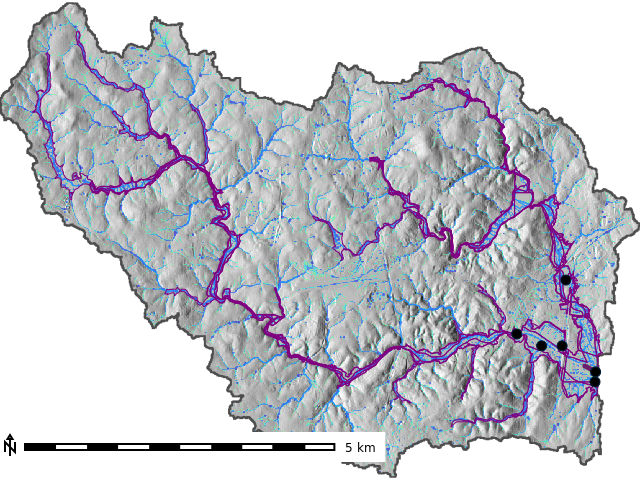

In [194]:
simwe(cluster=1, elev=dem, nlcd=nlcd_2016, display=True)

Total Buildings: 11651


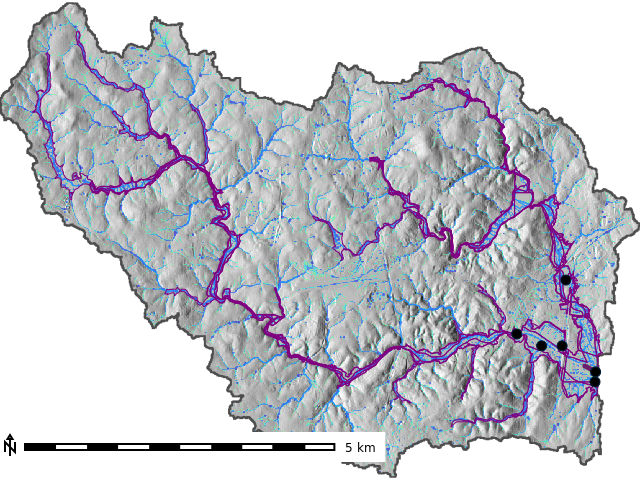

In [195]:
display_simwe_depth_map(1)

Total Buildings: 52660


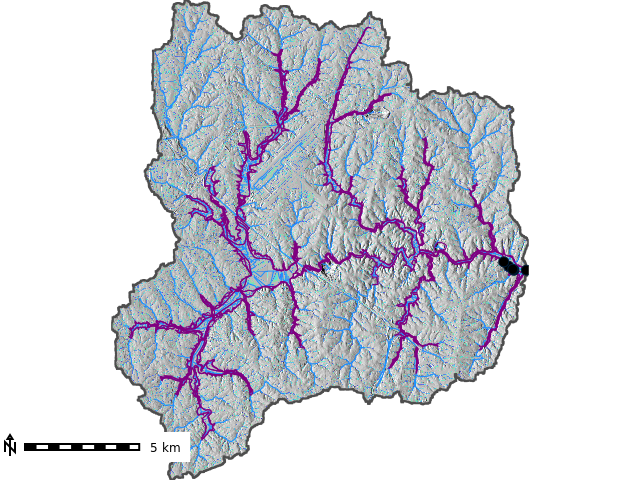

In [196]:
display_simwe_depth_map(2)

Total Buildings: 896


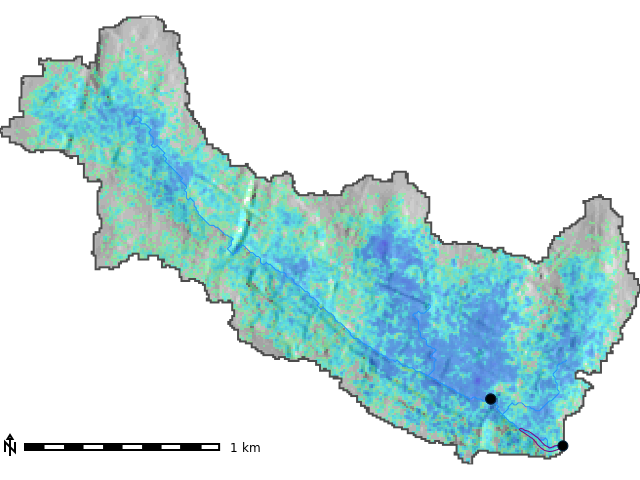

In [197]:
display_simwe_depth_map(3)

In [212]:
def display_inundation_map(cluster):

    cluster_idx = cluster -1 # Cluster index used to find in list
    gs.run_command('g.region', vector=cluster_contributing_areas[cluster_idx], res=10, flags='pg')
    gs.run_command("r.mask", vector=cluster_contributing_areas[cluster_idx], overwrite=True)
    inundation_hillshade_blend = "cluster_{}_inundation_1m_hillshade_blend".format(cluster)
    gs.run_command("r.blend", first=inundation, second=hillshade, output=inundation_hillshade_blend, flags="c")

    # Mpa Depth
    
    gs.run_command('d.erase')

    gs.run_command('d.rast', map=inundation_hillshade_blend)
   
    gs.run_command('d.vect', map=cluster_contributing_areas[cluster_idx],color="77:77:77:255", fill_color="none", width=2)
    gs.run_command('d.vect', map=cluster_contrib_streams_list[cluster_idx], color="30:144:255:255")
    # gs.run_command('d.vect', map=floodplain)
    #  gs.run_command('d.rast', map=inundation)
    # gs.run_command('d.vect', map=cluster_floodplains[cluster_idx], color="128:0:128:255", fill_color="none")
    total_buildings = gs.parse_command('v.info', map=cluster_building_footprints[cluster_idx], flags='get')
    print("Total Buildings: {}".format(total_buildings['areas']))
    
    gs.run_command('d.vect', map=cluster_outlets[cluster_idx], icon="basic/point",fill_color="black", layer=2, size=20)
    # gs.run_command('d.legend', flags="bl", raster=filtered_depth, title="Water Depth (m)")


    gs.run_command('d.barscale', flags='n')
    return Image(filename="map.png")

Total Buildings: 11651


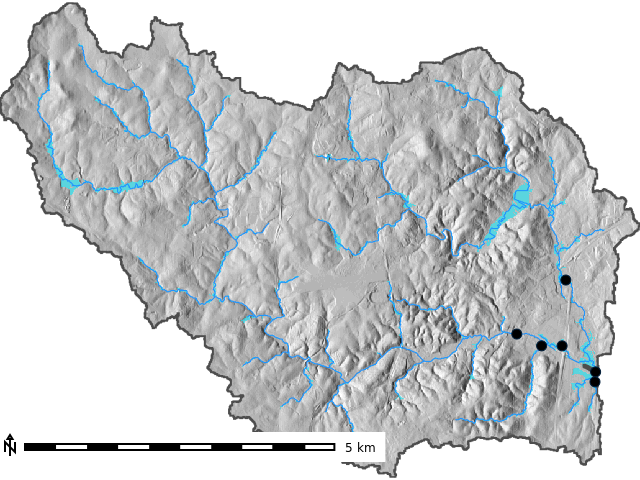

In [213]:
display_inundation_map(1)

Total Buildings: 52660


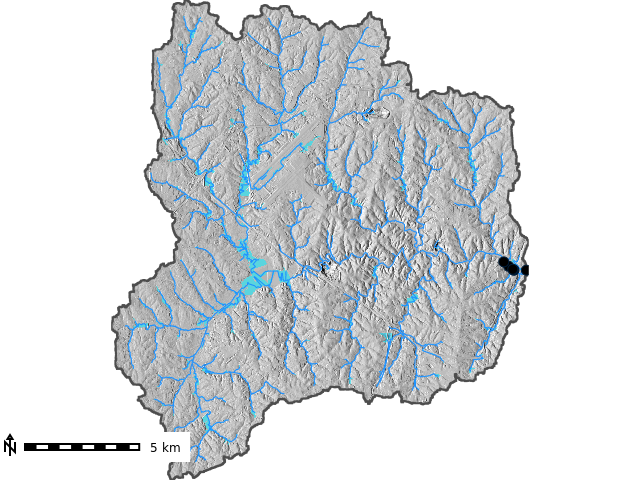

In [214]:
display_inundation_map(2)

In [78]:
inundation = calculateHAND(depth=2)

In [204]:
def display_floodplain_map(cluster):

    cluster_idx = cluster -1 # Cluster index used to find in list
    gs.run_command('g.region', vector=cluster_contributing_areas[cluster_idx], res=10, flags='pg')
    gs.run_command("r.mask", vector=cluster_contributing_areas[cluster_idx], overwrite=True)
    
    # Mpa Depth
    
    gs.run_command('d.erase')

    gs.run_command('d.rast', map=nlcd_2016_blend)
   
    gs.run_command('d.vect', map=cluster_contributing_areas[cluster_idx],color="77:77:77:255", fill_color="none", width=2)
    gs.run_command('d.vect', map=cluster_contrib_streams_list[cluster_idx], color="30:144:255:255")
    # gs.run_command('d.vect', map=floodplain)
    #  gs.run_command('d.rast', map=inundation)
    gs.run_command('d.vect', map=cluster_floodplains[cluster_idx], color="128:0:128:255", fill_color="none")
    total_buildings = gs.parse_command('v.info', map=cluster_building_footprints[cluster_idx], flags='get')
    print("Total Buildings: {}".format(total_buildings['areas']))
    
    gs.run_command('d.vect', map=cluster_outlets[cluster_idx], icon="basic/point",fill_color="black", layer=2, size=20)
    # gs.run_command('d.legend', flags="bl", raster=filtered_depth, title="Water Depth (m)")


    gs.run_command('d.barscale', flags='n')
    return Image(filename="map.png")

Total Buildings: 11651


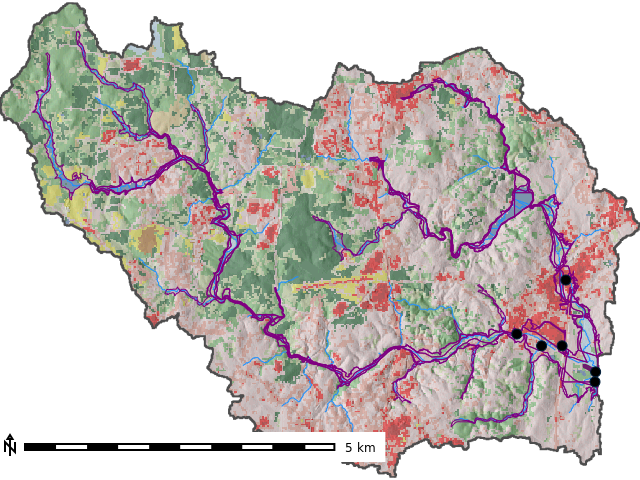

In [205]:
display_floodplain_map(1)

Total Buildings: 52660


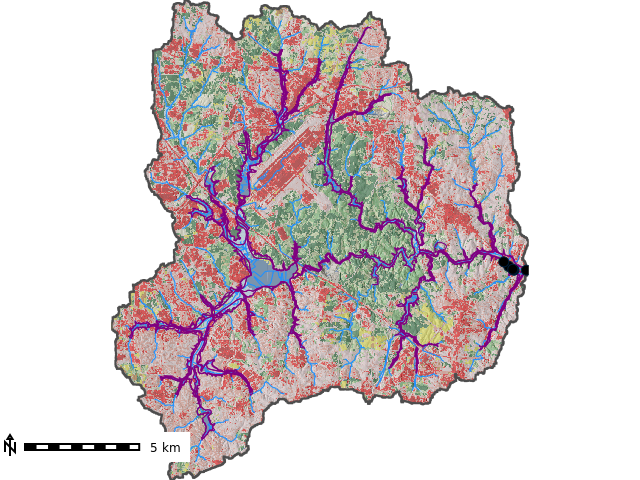

In [202]:
display_floodplain_map(2)

Total Buildings: 896


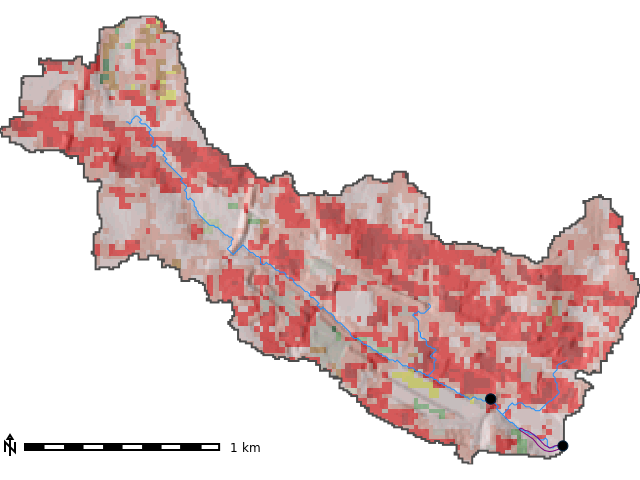

In [203]:
display_floodplain_map(3)

In [ ]:
## Wordcloud

# Cluster features or vorroni polygons
# For each cluster calculate convex hull
# For each cluster calculate the weight of each word used in specified field
# Set threshold for word inclusion
# Generate n points in the convex hull 
# Assign each point the word and weight 
# Set the point labels to the word field and the font size to the weight field
# Randomly assign word angle
# Set no colisions

def wordcloud(input, type, layer, output):
    """

    """




In [ ]:
# Read Grass Data into geopandas dataframe
import fiona
import geopandas as gpd

fiona.supported_drivers["OGR_GRASS"] = "r" 
cluster_data = "/home/coreywhite/Documents/grassdata/wrri_nad83_6542/tomorrownow/vector/{}/head".format(clusters[0])
gdf = gpd.read_file(cluster_data)
gdf.head()

In [351]:
# Mask 
gs.parse_command('g.region', vector=research_triangle_huc12, res=10, flags='pg')
gs.run_command("r.mask", flags="r")
gs.run_command("r.blend", first=nlcd_2016, second=hillshade, output=nlcd_2016_blend, flags="c")